<a href="https://colab.research.google.com/github/TruonghocAI/Cassava_Leaf_Disease/blob/main/ViT_model_pre_trained_on_ImageNet_21k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1F8NqsM04hDU8wgW1OiWM5-WZiaswxIoR

Downloading...
From (original): https://drive.google.com/uc?id=1F8NqsM04hDU8wgW1OiWM5-WZiaswxIoR
From (redirected): https://drive.google.com/uc?id=1F8NqsM04hDU8wgW1OiWM5-WZiaswxIoR&confirm=t&uuid=dcc24746-6d51-48ee-a85f-f976c8b3b26c
To: /content/cassavaleafdata.zip
100% 1.35G/1.35G [00:17<00:00, 77.3MB/s]


In [2]:
! unzip /content/cassavaleafdata.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: cassavaleafdata/train/cgm/train-cgm-679.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-68.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-680.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-681.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-682.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-683.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-684.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-685.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-686.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-687.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-688.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-689.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-69.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-690.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-691.jpg  
  inflating: cassavaleafdata/train/cgm/train-cgm-692.jpg  
 

In [3]:
!pip install -q transformers datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data

from torchsummary import summary
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [5]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
data_paths = {
    'train': '/content/cassavaleafdata/train',
    'valid': '/content/cassavaleafdata/validation',
    'test': '/content/cassavaleafdata/test'
}

In [7]:
from transformers import ViTImageProcessor

feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

image_mean = feature_extractor.image_mean
image_std = feature_extractor.image_std
image_height = feature_extractor.size['height']
image_width = feature_extractor.size['width']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [8]:
from torchvision import transforms, datasets


train_transform = transforms.Compose([
    transforms.RandomResizedCrop((image_height, image_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std)
])

test_transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std)
])

In [9]:
def loader(path):
    return Image.open(path)

train_data = datasets.ImageFolder(
    root=data_paths['train'],
    loader=loader,
    transform=train_transform
)
valid_data = datasets.ImageFolder(
    root=data_paths['valid'],
    transform=train_transform
)
test_data = datasets.ImageFolder(
    root=data_paths['test'],
    transform=train_transform
)

In [10]:
BATCH_SIZE = 512

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)
valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

len(train_dataloader)

12

In [11]:
from transformers import ViTForImageClassification

class_names = train_data.classes

label2id = {label: idx for idx, label in enumerate(class_names)}
id2label = {idx: label for idx, label in enumerate(class_names)}

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(class_names),
    id2label=id2label,
    label2id=label2id
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"cassava_leaf_disease",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [20]:
import torch

def collate_fn(examples):
    # example => Tuple(image, label)
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=valid_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

<ipython-input-20-f13e305d9456>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.470461,0.862890
2,No log,0.428639,0.880889
3,No log,0.429769,0.870302
4,No log,0.403756,0.884066
5,No log,0.399943,0.887771


TrainOutput(global_step=445, training_loss=0.385330611668276, metrics={'train_runtime': 1361.6914, 'train_samples_per_second': 20.768, 'train_steps_per_second': 0.327, 'total_flos': 2.191532390751191e+18, 'train_loss': 0.385330611668276, 'epoch': 5.0})

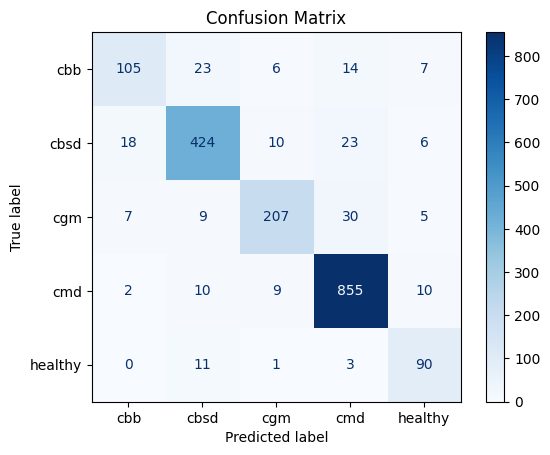

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Lấy dự đoán và nhãn thực tế
predictions = trainer.predict(test_data)
pred_probs = predictions.predictions
y_pred = pred_probs.argmax(axis=-1)
y_true = predictions.label_ids

# Tạo và vẽ confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(trainer.model.config.id2label.values()))
disp.plot(cmap='Blues', values_format='d')

# Hiển thị
plt.title("Confusion Matrix")
plt.show()
